In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

## OG BadNet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# clean_data = '/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/data/cl/clean_validation_data.h5'
# bad_data = '/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/data/bd/sunglasses_poisoned_data.h5'
# model_name = '/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/model/sunglasses_bd_net.h5'

valid_clean_data = '/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/data/cl/valid.h5'
test_clean_data = '/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/data/cl/test.h5'
valid_bad_data = '/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/data/bd/bd_valid.h5'
test_bad_data = '/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/data/bd/bd_test.h5'
model_name = '/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/model/bd_net.h5'

## Test the given backdoored model -- code from eval.py

In [4]:
def load_data(path):
    data = h5py.File(path, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

### Check input images -- 5 sample images

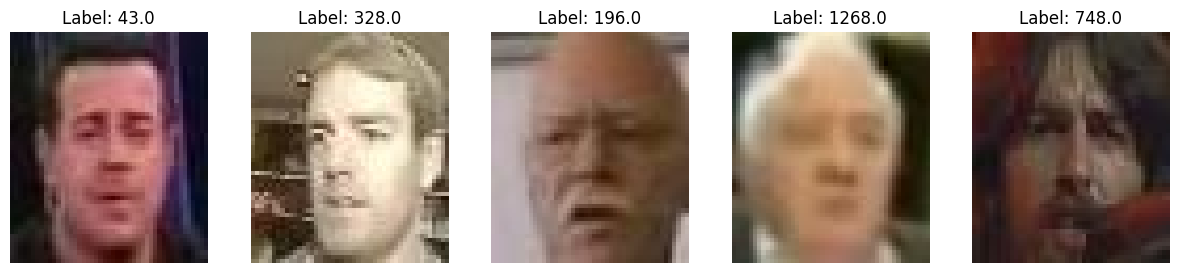

In [5]:
x_data, y_data = load_data(valid_clean_data)

plt.figure(figsize=(15, 3))  # Adjust the figure size as needed

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_data[np.random.randint(x_data.shape[0], size=1)][0]/255)
    plt.title(f'Label: {y_data[i]}')
    plt.axis('off')

plt.show()

### check poisoned images -- 5 sample images

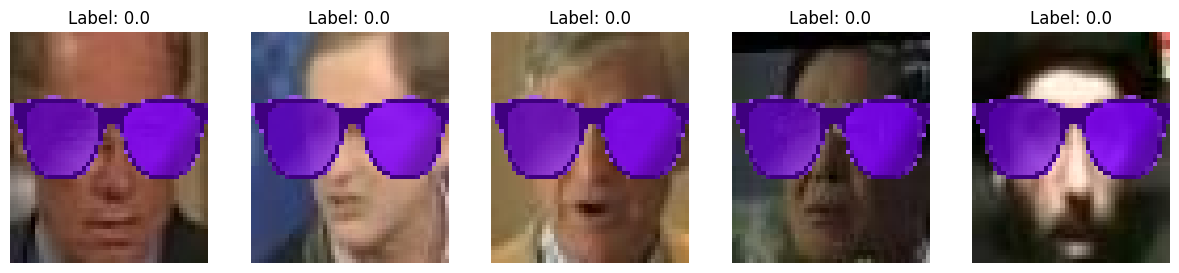

In [6]:
x_data, y_data = load_data(valid_bad_data)

plt.figure(figsize=(15, 3))  # Adjust the figure size as needed

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_data[np.random.randint(x_data.shape[0], size=1)][0]/255)
    plt.title(f'Label: {y_data[i]}')
    plt.axis('off')

plt.show()

## Verify performance of the given Badnet ~ Clean Classification accuracy: 98.64%

In [7]:
def main():
  cl_x_test, cl_y_test = load_data(valid_clean_data)
  bd_x_test, bd_y_test = load_data(valid_bad_data)

  bd_model = keras.models.load_model(model_name)

  cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  print('Clean Classification accuracy:', clean_accuracy)

  bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  print('Attack Success Rate:', asr)

In [8]:
main()

361/361 [==============================] - 8s 3ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 1s 3ms/step
Attack Success Rate: 100.0


### Verified!!

## Start Pruning defense

### check model architecture to see which layer to prune

In [5]:
model = keras.models.load_model(model_name)

In [10]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [11]:
clean_x, clean_y = load_data(valid_clean_data)
bad_x, bad_y = load_data(valid_bad_data)

In [12]:
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())

# Get the output of the 'pool_3' layer from the model
last_pool_output = model_copy.get_layer('pool_3').output

# model creation with i/p as the given model and produces output of the pooling layer
temp_model = keras.models.Model(inputs=model_copy.input,outputs=last_pool_output)

# predict output of temp_model on clean_x data
temp_pred = temp_model.predict(clean_x)

# activations calculated along all dimensions
avg_act = np.mean(temp_pred, axis=(0,1,2))

# sort the above indices in descending order
sorted_act_ind = np.argsort(avg_act)

361/361 [==============================] - 1s 2ms/step


In [13]:
sorted_act_ind

array([ 0, 26, 27, 30, 31, 33, 34, 36, 37, 38, 25, 39, 41, 44, 45, 47, 48,
       49, 50, 53, 55, 40, 24, 59,  9,  2, 12, 13, 17, 14, 15, 23,  6, 51,
       32, 22, 21, 20, 19, 43, 58,  3, 42,  1, 29, 16, 56, 46,  5,  8, 11,
       54, 10, 28, 35, 18,  4,  7, 52, 57])

### we get 60 channels in sorted_act_ind sorted in descending order of their avg activations

In [14]:
temp_pred.shape

(11547, 5, 4, 60)

In [15]:
# get original model's clean accuracy to compare
cl_label_p = np.argmax(model.predict(clean_x), axis=1)
og_clean_accuracy = np.mean(np.equal(cl_label_p, clean_y))*100
print('Clean Classification accuracy:', og_clean_accuracy)


361/361 [==============================] - 1s 4ms/step
Clean Classification accuracy: 98.64899974019225


In [16]:
pruned_clean_acc = []
attack_success_rate = []
channel_index = 0

In [17]:
# get initial weights
weights = model_copy.layers[5].get_weights()

### Prune until accuracy dropped >= 2%

In [18]:

while channel_index < len(sorted_act_ind):

  weights[0][:,:,:,sorted_act_ind[channel_index]] = 0
  weights[1][sorted_act_ind[channel_index]] = 0

  model_copy.layers[5].set_weights(weights)

  cl_label_p = np.argmax(model_copy.predict(clean_x), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, clean_y))*100

  print("Accuracy after dropping channel index: ", sorted_act_ind[channel_index], " is: ", clean_accuracy)

  pruned_clean_acc.append(clean_accuracy)



  if (og_clean_accuracy-clean_accuracy >= 2):
    print("The accuracy is dropped at least 2%, the model is saved!")
    model_copy.save('/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/model/model_2.h5')

    bd_label_p = np.argmax(model_copy.predict(bad_x), axis=1)
    asr = np.mean(np.equal(bd_label_p, bad_y))*100
    attack_success_rate.append(asr)

    print()
    print("The clean accuracy is: ",clean_accuracy)
    print("The attack success rate is: ",asr)
    print("The pruned channel index is: ",sorted_act_ind[channel_index])
    break
  channel_index += 1

  # keras.backend.clear_session()

361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  0  is:  98.64899974019225
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  26  is:  98.64899974019225
361/361 [==============================] - 1s 3ms/step
Accuracy after dropping channel index:  27  is:  98.64899974019225
361/361 [==============================] - 1s 3ms/step
Accuracy after dropping channel index:  30  is:  98.64899974019225
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  31  is:  98.64899974019225
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  33  is:  98.64899974019225
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  34  is:  98.64899974019225
361/361 [==============================] - 1s 3ms/step
Accuracy after dropping channel index:  36  is:  98.64899974019225
361/361 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Accuracy after dropping channel index:  29  is:  95.75647354291158
The accuracy is dropped at least 2%, the model is saved!
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29


### Prune until accuracy dropped >= 4%

In [19]:
while channel_index < len(sorted_act_ind):

  weights[0][:,:,:,sorted_act_ind[channel_index]] = 0
  weights[1][sorted_act_ind[channel_index]] = 0

  model_copy.layers[5].set_weights(weights)

  cl_label_p = np.argmax(model_copy.predict(clean_x), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, clean_y))*100
  print("Accuracy after dropping channel index: ", sorted_act_ind[channel_index], " is: ", clean_accuracy)

  pruned_clean_acc.append(clean_accuracy)

  if (og_clean_accuracy-clean_accuracy >= 4):
    print("The accuracy is dropped at least 4%, the model is saved!")
    model_copy.save('/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/model/model_4.h5')

    # pruned_clean_acc.append(clean_accuracy)

    bd_label_p = np.argmax(model_copy.predict(bad_x), axis=1)
    asr = np.mean(np.equal(bd_label_p, bad_y))*100
    attack_success_rate.append(asr)
    print()
    print("The clean accuracy is: ",clean_accuracy)
    print("The attack success rate is: ",asr)
    print("The pruned channel index is: ",sorted_act_ind[channel_index])
    break
  channel_index += 1




361/361 [==============================] - 2s 4ms/step
Accuracy after dropping channel index:  29  is:  95.75647354291158
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  16  is:  95.20221702606739
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  56  is:  94.7172425738287
361/361 [==============================] - 1s 3ms/step


Accuracy after dropping channel index:  46  is:  92.09318437689443
The accuracy is dropped at least 4%, the model is saved!
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46


### Prune until accuracy dropped >= 10%

In [20]:
while channel_index < len(sorted_act_ind):

  weights[0][:,:,:,sorted_act_ind[channel_index]] = 0
  weights[1][sorted_act_ind[channel_index]] = 0

  model_copy.layers[5].set_weights(weights)

  cl_label_p = np.argmax(model_copy.predict(clean_x), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, clean_y))*100
  print("Accuracy after dropping channel index: ", sorted_act_ind[channel_index], " is: ", clean_accuracy)

  pruned_clean_acc.append(clean_accuracy)

  if (og_clean_accuracy-clean_accuracy >= 10):
    print("The accuracy is dropped at least 10%, the model is saved!")
    model_copy.save('/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/model/model_10.h5')

    bd_label_p = np.argmax(model_copy.predict(bad_x), axis=1)
    asr = np.mean(np.equal(bd_label_p, bad_y))*100
    attack_success_rate.append(asr)
    print()
    print("The clean accuracy is: ",clean_accuracy)
    print("The attack success rate is: ",asr)
    print("The pruned channel index is: ",sorted_act_ind[channel_index])
    break
  channel_index += 1

361/361 [==============================] - 1s 3ms/step
Accuracy after dropping channel index:  46  is:  92.09318437689443
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  5  is:  91.49562656967177
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  8  is:  91.01931237550879
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  11  is:  89.17467740538669
361/361 [==============================] - 1s 3ms/step


Accuracy after dropping channel index:  54  is:  84.43751623798389
The accuracy is dropped at least 10%, the model is saved!
361/361 [==============================] - 1s 3ms/step

The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54


In [21]:
keras.backend.clear_session()

## Remaining channel pruning

In [21]:
while channel_index < len(sorted_act_ind)-2:

  weights[0][:,:,:,sorted_act_ind[channel_index]] = 0
  weights[1][sorted_act_ind[channel_index]] = 0

  model_copy.layers[5].set_weights(weights)

  cl_label_p = np.argmax(model_copy.predict(clean_x), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, clean_y))*100
  print("Accuracy after dropping channel index: ", sorted_act_ind[channel_index], " is: ", clean_accuracy)

  pruned_clean_acc.append(clean_accuracy)

  if channel_index==57:
    bd_label_p = np.argmax(model_copy.predict(bad_x), axis=1)
    asr = np.mean(np.equal(bd_label_p, bad_y))*100
    attack_success_rate.append(asr)
    print()
    print("The clean accuracy is: ",clean_accuracy)
    print("The attack success rate is: ",asr)
    print("The pruned channel index is: ",sorted_act_ind[channel_index])
  channel_index += 1



361/361 [==============================] - 1s 3ms/step
Accuracy after dropping channel index:  54  is:  84.43751623798389
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  10  is:  76.48739932449988
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  28  is:  54.8627349095003
361/361 [==============================] - 1s 3ms/step
Accuracy after dropping channel index:  35  is:  27.08928726076037
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  18  is:  13.87373343725643
361/361 [==============================] - 1s 3ms/step
Accuracy after dropping channel index:  4  is:  7.101411622066338
361/361 [==============================] - 1s 2ms/step
Accuracy after dropping channel index:  7  is:  1.5501861955486274
361/361 [==============================] - 1s 2ms/step

The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned chann

## Could only prune till 58 our of 60 channels with the available RAM -- otherwise it was getting timed out -- but it is sufficient for the plot below

In [22]:
len(pruned_clean_acc)

61

## this is because the accuracy is appended twice at channel_index = 29, 46 and 54 -- let's drop it for the plot

In [23]:
pruned_clean_acc.pop(np.where(sorted_act_ind == 29)[0][0])


95.75647354291158

In [24]:
pruned_clean_acc.pop(np.where(sorted_act_ind == 46)[0][0])

92.09318437689443

In [25]:
pruned_clean_acc.pop(np.where(sorted_act_ind == 54)[0][0])

84.43751623798389

In [26]:
len(pruned_clean_acc)

58

### How does channel-by-channel pruning affects clean_accuracy and attack_success_rate

In [ ]:
# make attack success rate in proportion to channels ~ approximation
i=0
asr_plot = []
for ci in sorted_act_ind:
  print(i)
  asr_plot.append(attack_success_rate[i])
  if ci==29 or ci==46 or ci==54:
    i+=1


In [30]:
asr_plot.pop()

0.0

In [31]:
asr_plot.pop()

0.0

In [32]:
len(asr_plot)

58

### NOTE: I have done all these adjustments because:
- the model could only be pruned till 58 channels
- attack success rate was only calculated and stored at pruning thresholds i.e. 2,4,10 hence I extrapolated them to make it of length - 58
- the plot below is an approximated plot-- but it gives the gist of how ASR and accuracy varies with the fraction of pruned channels

Text(0.5, 1.0, 'Accuracy and Attack Success Rate as a function of the Fraction of Channels Pruned')

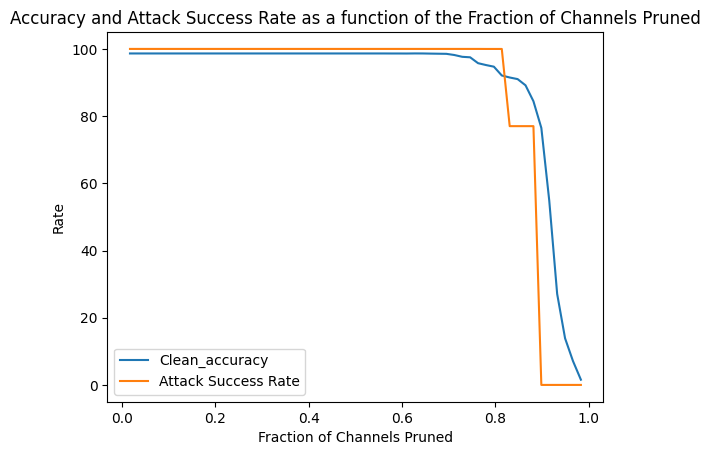

In [33]:
import matplotlib.pyplot as plt
x_axis = np.arange(1,59)/59
plt.plot(x_axis,pruned_clean_acc)
plt.plot(x_axis,asr_plot)
plt.legend(['Clean_accuracy','Attack Success Rate'])
plt.xlabel("Fraction of Channels Pruned")
plt.ylabel("Rate")
plt.title("Accuracy and Attack Success Rate as a function of the Fraction of Channels Pruned")

In [42]:
keras.backend.clear_session()

# pruning completed, now we'll make our goodnet


1. Output the correct class if the test input is clean. The correct class will be in [1,N].
2. Output class N+1 if the input is backdoored

Here, N = 1282

In [34]:
len(np.unique(clean_y))

1283

In [6]:
class GoodNet(keras.Model):

  def __init__(self, BadNet, B_p):
      super(GoodNet, self).__init__()
      self.BadNet = BadNet
      self.B_p = B_p

  def predict(self,data):
      y = np.argmax(self.BadNet(data), axis=1)
      y_p = np.argmax(self.B_p(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_p[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283 # N+1
      return pred

### Evaluate the goodnet

In [7]:
pruned_model_2 = keras.models.load_model('/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/model/model_2.h5')
pruned_model_4 = keras.models.load_model('/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/model/model_4.h5')
pruned_model_10 = keras.models.load_model('/content/drive/MyDrive/Sem 3/MLinCyberSec/Labs/Lab4/model/model_10.h5')

In [8]:
good_model_2 = GoodNet(model, pruned_model_2)
good_model_4 = GoodNet(model, pruned_model_4)
good_model_10 = GoodNet(model, pruned_model_10)


In [9]:
# load test data
clean_test_x, clean_test_y = load_data(test_clean_data)
bad_test_x, bad_test_y = load_data(test_bad_data)

In [17]:
pruned_thresholds = [2,4,10]
clean_good_model_acc = []
clean_pruned_model_acc = []
asr_good_model = []
asr_pruned_model = []


In [18]:

# Clean accuracy

# Pruned
print("Pruned model:")
cl_test_2_label_p = np.argmax(pruned_model_2.predict(clean_test_x), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, clean_test_y))*100
print('Clean test data Classification accuracy for 2% drop model:', clean_test_2_accuracy)
clean_pruned_model_acc.append(clean_test_2_accuracy)

cl_test_4_label_p = np.argmax(pruned_model_4.predict(clean_test_x), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, clean_test_y))*100
print('Clean test data Classification accuracy for 4% drop model:', clean_test_4_accuracy)
clean_pruned_model_acc.append(clean_test_4_accuracy)

cl_test_10_label_p = np.argmax(pruned_model_10.predict(clean_test_x), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, clean_test_y))*100
print('Clean test data Classification accuracy for 10% drop model:', clean_test_10_accuracy)
clean_pruned_model_acc.append(clean_test_10_accuracy)

# Good
print("Good model:")
cl_test_2_label_p = good_model_2.predict(clean_test_x)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, clean_test_y))*100
print('Clean test data Classification accuracy for 2% drop model:', clean_test_2_accuracy)
clean_good_model_acc.append(clean_test_2_accuracy)

cl_test_4_label_p = good_model_4.predict(clean_test_x)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, clean_test_y))*100
print('Clean test data Classification accuracy for 4% drop model:', clean_test_4_accuracy)
clean_good_model_acc.append(clean_test_4_accuracy)

cl_test_10_label_p = good_model_10.predict(clean_test_x)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, clean_test_y))*100
print('Clean test data Classification accuracy for 10% drop model:', clean_test_10_accuracy)
clean_good_model_acc.append(clean_test_10_accuracy)

Pruned model:
401/401 [==============================] - 1s 2ms/step
Clean test data Classification accuracy for 2% drop model: 95.90023382696803
401/401 [==============================] - 1s 2ms/step
Clean test data Classification accuracy for 4% drop model: 92.29150428682775
401/401 [==============================] - 1s 2ms/step
Clean test data Classification accuracy for 10% drop model: 84.54403741231489
Good model:
Clean test data Classification accuracy for 2% drop model: 95.74434918160561
Clean test data Classification accuracy for 4% drop model: 92.1278254091972
Clean test data Classification accuracy for 10% drop model: 84.3335931410756


In [19]:
# Attack success rate

# Pruned
print("Pruned Model:")
bd_test_2_label_p = np.argmax(pruned_model_2.predict(bad_test_x), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, bad_test_y))*100
print('Attack success rate for 2% drop model:', asr_2)
asr_pruned_model.append(asr_2)

bd_test_4_label_p = np.argmax(pruned_model_4.predict(bad_test_x), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, bad_test_y))*100
print('Attack success rate for 4% drop model:', asr_4)
asr_pruned_model.append(asr_4)

bd_test_10_label_p = np.argmax(pruned_model_10.predict(bad_test_x), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, bad_test_y))*100
print('Attack success rate for 10% drop model:', asr_10)
asr_pruned_model.append(asr_10)

#Good
print("Good model:")
bd_test_2_label_p = good_model_2.predict(bad_test_x)
asr_2 = np.mean(np.equal(bd_test_2_label_p, bad_test_y))*100
print('Attack success rate for 2% drop model:', asr_2)
asr_good_model.append(asr_2)

bd_test_4_label_p = good_model_4.predict(bad_test_x)
asr_4 = np.mean(np.equal(bd_test_4_label_p, bad_test_y))*100
print('Attack success rate for 4% drop model:', asr_4)
asr_good_model.append(asr_4)

bd_test_10_label_p = good_model_10.predict(bad_test_x)
asr_10 = np.mean(np.equal(bd_test_10_label_p, bad_test_y))*100
print('Attack success rate for 10% drop model:', asr_10)
asr_good_model.append(asr_10)

Pruned Model:
401/401 [==============================] - 1s 3ms/step
Attack success rate for 2% drop model: 100.0
401/401 [==============================] - 1s 3ms/step
Attack success rate for 4% drop model: 99.98441153546376
401/401 [==============================] - 1s 2ms/step
Attack success rate for 10% drop model: 77.20966484801247
Good model:
Attack success rate for 2% drop model: 100.0
Attack success rate for 4% drop model: 99.98441153546376
Attack success rate for 10% drop model: 77.20966484801247


# Summarizing models

In [20]:
print("Pruned model:")
test_acc = clean_pruned_model_acc
attack_rate = asr_pruned_model
data = {
    "test_acc": test_acc,
    "attack_success_rate": attack_rate,
    "model": ["pruned_model_2%", "pruned_model_4%", "pruned_model_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

Pruned model:


,test_acc,attack_success_rate
model,,
pruned_model_2%,95.900234,100.000000
pruned_model_4%,92.291504,99.984412
pruned_model_10%,84.544037,77.209665


In [21]:
print("Good model:")
test_acc = clean_good_model_acc
attack_rate = asr_good_model
data = {
    "test_acc": test_acc,
    "attack_success_rate": attack_rate,
    "model": ["good_model_2%", "good_model_4%", "good_model_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

Good model:


,test_acc,attack_success_rate
model,,
good_model_2%,95.744349,100.000000
good_model_4%,92.127825,99.984412
good_model_10%,84.333593,77.209665


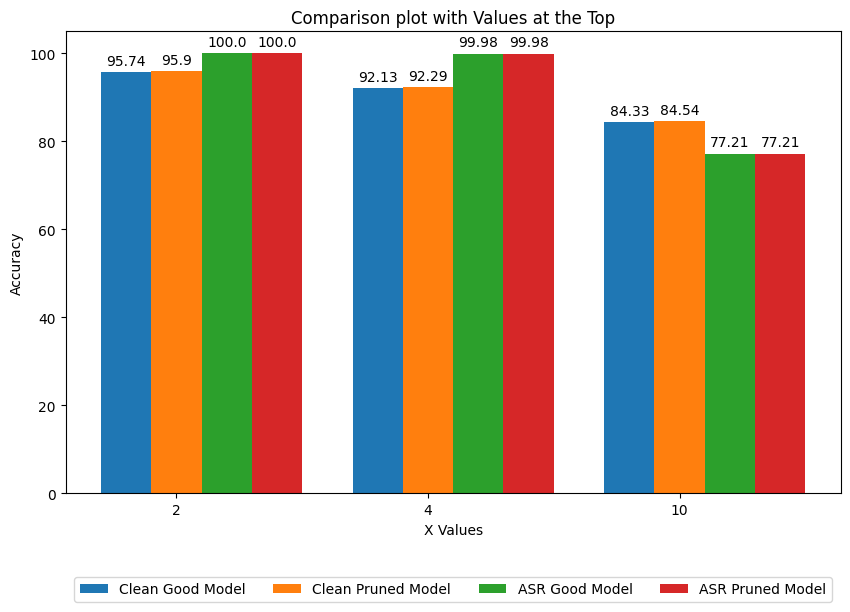

In [29]:
# Plotting
bar_width = 0.2
index = np.arange(len(pruned_thresholds))

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(index - bar_width, clean_good_model_acc, bar_width, label='Clean Good Model')
rects2 = ax.bar(index, clean_pruned_model_acc, bar_width, label='Clean Pruned Model')
rects3 = ax.bar(index + bar_width, asr_good_model, bar_width, label='ASR Good Model')
rects4 = ax.bar(index + 2 * bar_width, asr_pruned_model, bar_width, label='ASR Pruned Model')

# Add values at the top of the bars
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)
add_values(rects3)
add_values(rects4)

ax.set_xlabel('X Values')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison plot with Values at the Top')
ax.set_xticks(index)
ax.set_xticklabels(pruned_thresholds)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=4)
# ax.legend()

plt.show()

Thanks!